In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 2. 配置参数 ---
input_filename = 'stressfile.csv'
output_filename = 'stress_field_completed.csv'

print("--- 应力场数据处理脚本 (修正版) ---")
print(f"输入文件: {input_filename}")
print(f"输出文件: {output_filename}")
print("-" * 40)


# --- 3. 读取数据并动态推断网格参数 ---
print("正在读取数据并动态推断网格参数...")

try:
    # 假设你的 CSV 文件只有 X, Y, Z, Trace 四列，且没有 ID
    df_raw = pd.read_csv(input_filename, header=None, names=['X', 'Y', 'Z', 'Trace'])
except FileNotFoundError:
    print(f"错误：文件 '{input_filename}' 未找到。请检查文件名和路径。")
    exit()
df_raw = df_raw.apply(pd.to_numeric, errors='coerce')

# 删除所有包含 NaN 的行（即删除了非数值的行）
df_raw.dropna(inplace=True)

--- 应力场数据处理脚本 (修正版) ---
输入文件: stressfile.csv
输出文件: stress_field_completed.csv
----------------------------------------
正在读取数据并动态推断网格参数...


In [25]:
unique_x = np.sort(df_raw['X'].unique())
unique_y = np.sort(df_raw['Y'].unique())
unique_z = np.sort(df_raw['Z'].unique())
print(unique_x)
# 推断网格点数和间距
nx = len(unique_x)
ny = len(unique_y)
nz = len(unique_z)
dx = unique_x[1] - unique_x[0] if num_points_per_dim > 1 else 0
dy = unique_y[1] - unique_y[0] if num_points_per_dim > 1 else 0
dz = unique_z[1] - unique_z[0] if num_points_per_dim > 1 else 0
box_size = unique_x[-1] - unique_x[0] if num_points_per_dim > 1 else 0

print(f"网格推断完成：")
print(f"  每个维度点数: nx={nx}, ny={ny}, nz={nz}")
print(f"  网格间距: dx={dx:.2e}, dy={dy:.2e}, dz={dz:.2e}")


[2.0e-05 4.0e-05 6.0e-05 8.0e-05 1.0e-04 1.2e-04 1.4e-04 1.6e-04 1.8e-04
 2.0e-04 2.2e-04 2.4e-04 2.6e-04 2.8e-04 3.0e-04 3.2e-04 3.4e-04 3.6e-04
 3.8e-04 4.0e-04 4.2e-04 4.4e-04 4.6e-04 4.8e-04]
网格推断完成：
  每个维度点数: nx=24, ny=24, nz=23
  网格间距: dx=2.00e-05, dy=2.00e-05, dz=2.00e-05


In [26]:
trace_grid = np.full((nx, ny, nz), np.nan)

# 将原始数据填充到网格中
x_to_i = {x: i for i, x in enumerate(unique_x)}
y_to_j = {y: j for j, y in enumerate(unique_y)}
z_to_k = {z: k for k, z in enumerate(unique_z)}

for _, row in df_raw.iterrows():
    i = x_to_i[row['X']]
    j = y_to_j[row['Y']]
    k = z_to_k[row['Z']]
    trace_grid[i, j, k] = row['Trace']

print("原始数据成功映射到网格。缺失点的数量:", np.sum(np.isnan(trace_grid)))



原始数据成功映射到网格。缺失点的数量: 4252


In [27]:
# --- 4. 补全缺失点（迭代线性外推） ---
print("正在补全缺失点...")
trace_grid_filled = np.copy(trace_grid)
num_filled_in_last_pass = -1
while num_filled_in_last_pass != 0:
    num_missing_before_pass = np.sum(np.isnan(trace_grid_filled))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if np.isnan(trace_grid_filled[i, j, k]):
                    neighbors = []
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            for dk in [-1, 0, 1]:
                                if di == 0 and dj == 0 and dk == 0: continue
                                ni, nj, nk = i + di, j + dj, k + dk
                                if 0 <= ni < nx and 0 <= nj < ny and 0 <= nk < nz:
                                    if not np.isnan(trace_grid_filled[ni, nj, nk]):
                                        neighbors.append(trace_grid_filled[ni, nj, nk])
                    if neighbors:
                        trace_grid_filled[i, j, k] = np.mean(neighbors)
    num_missing_after_pass = np.sum(np.isnan(trace_grid_filled))
    num_filled_in_last_pass = num_missing_before_pass - num_missing_after_pass
    print(f"  本次迭代填充了 {num_filled_in_last_pass} 个点。")
print("缺失点已补全。")
print("补全后缺失点的数量:", np.sum(np.isnan(trace_grid_filled)))


正在补全缺失点...
  本次迭代填充了 4188 个点。
  本次迭代填充了 63 个点。
  本次迭代填充了 1 个点。
  本次迭代填充了 0 个点。
缺失点已补全。
补全后缺失点的数量: 0


In [28]:
# --- 5. 计算梯度（带周期性边界条件） ---
print("正在计算应力梯度...")
grad_x_grid = np.zeros_like(trace_grid_filled)
grad_y_grid = np.zeros_like(trace_grid_filled)
grad_z_grid = np.zeros_like(trace_grid_filled)
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            ip = (i + 1) % nx; im = (i - 1 + nx) % nx
            jp = (j + 1) % ny; jm = (j - 1 + ny) % ny
            kp = (k + 1) % nz; km = (k - 1 + nz) % nz
            if dx > 0: grad_x_grid[i, j, k] = (trace_grid_filled[ip, j, k] - trace_grid_filled[im, j, k]) / (2 * dx)
            if dy > 0: grad_y_grid[i, j, k] = (trace_grid_filled[i, jp, k] - trace_grid_filled[i, jm, k]) / (2 * dy)
            if dz > 0: grad_z_grid[i, j, k] = (trace_grid_filled[i, j, kp] - trace_grid_filled[i, j, km]) / (2 * dz)
print("应力梯度计算完成。")

正在计算应力梯度...
应力梯度计算完成。


In [29]:
# --- 归一化梯度向量 ---
print("正在对梯度向量进行归一化...")
grad_magnitude_grid = np.sqrt(grad_x_grid**2 + grad_y_grid**2 + grad_z_grid**2)
normalized_grad_x_grid = np.zeros_like(grad_x_grid)
normalized_grad_y_grid = np.zeros_like(grad_y_grid)
normalized_grad_z_grid = np.zeros_like(grad_z_grid)
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            magnitude = grad_magnitude_grid[i, j, k]
            if magnitude > 1e-15:
                normalized_grad_x_grid[i, j, k] = grad_x_grid[i, j, k] / magnitude
                normalized_grad_y_grid[i, j, k] = grad_y_grid[i, j, k] / magnitude
                normalized_grad_z_grid[i, j, k] = grad_z_grid[i, j, k] / magnitude
print("梯度向量归一化完成。")


正在对梯度向量进行归一化...
梯度向量归一化完成。


In [30]:
# --- 6. 重建最终 DataFrame 并保存到 CSV ---
print("正在重建最终 DataFrame...")
# --- 关键修改点 2：使用推断出的独特坐标数组重建网格 ---
full_x_coords, full_y_coords, full_z_coords = np.meshgrid(unique_x, unique_y, unique_z, indexing='ij')

df_final = pd.DataFrame({
    'ID': range(nx * ny * nz),
    'X': full_x_coords.flatten(),
    'Y': full_y_coords.flatten(),
    'Z': full_z_coords.flatten(),
    'Trace': trace_grid_filled.flatten(),
    'GradX': normalized_grad_x_grid.flatten(),
    'GradY': normalized_grad_y_grid.flatten(),
    'GradZ': normalized_grad_z_grid.flatten(),
})

df_final.to_csv(output_filename, index=False)
print(f"最终数据已成功保存到 '{os.path.abspath(output_filename)}'")
print("-" * 40)

正在重建最终 DataFrame...
最终数据已成功保存到 '/Users/cool/Desktop/tensor/off_lattice_kmc/stress_field_completed.csv'
----------------------------------------


正在绘制可视化图表...


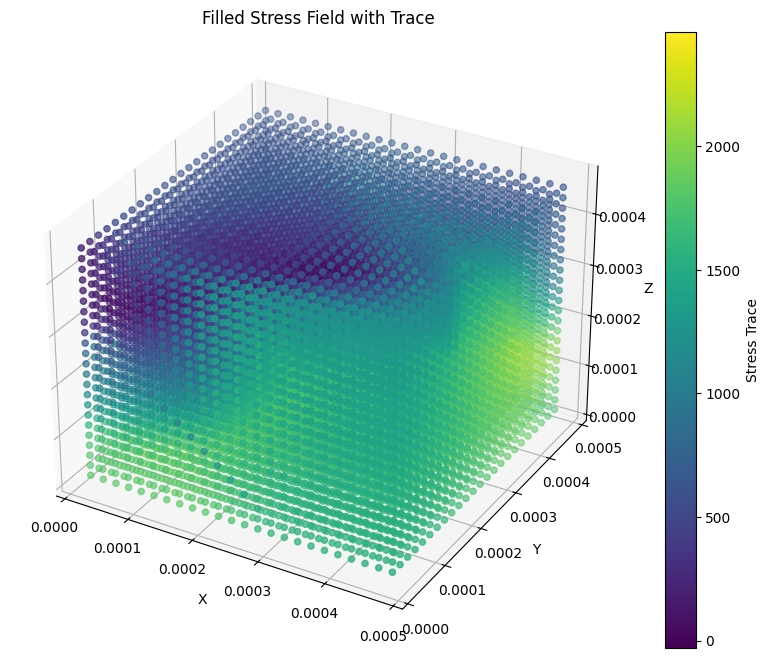

In [31]:
# --- (可选) 7. 可视化结果 ---
print("正在绘制可视化图表...")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_final['X'], df_final['Y'], df_final['Z'], c=df_final['Trace'], cmap='viridis', s=20)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Filled Stress Field with Trace')
fig.colorbar(scatter, label='Stress Trace')
plt.show()